[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Munyi-James173/Data-Science/blob/main/Capstone_Project/Data%20Oracles.ipynb)


In [46]:
# 1) Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


#  Gathering the Data

In [47]:
# data_path = "C:/Users/User/Desktop/Capstone"
# files = os.listdir(data_path)
# print(files)

In [48]:
# Reading the file datasets file from github

pesticides_df = r'https://github.com/Munyi-James173/Data-Science/blob/main/Capstone_Project/pesticides.csv'
rainfall_df = r'https://github.com/Munyi-James173/Data-Science/blob/main/Capstone_Project/rainfall.csv'
temp_df = r'https://github.com/Munyi-James173/Data-Science/blob/main/Capstone_Project/temp.csv'
yield_df = r'https://github.com/Munyi-James173/Data-Science/blob/main/Capstone_Project/yield.csv'
yield_df_df =r'https://github.com/Munyi-James173/Data-Science/blob/main/Capstone_Project/yield_df.csv'

In [49]:
# Convert GitHub file page URLs to raw URLs and read CSVs robustly
def to_raw_github(url: str) -> str:
    if isinstance(url, str) and "github.com" in url:
        return url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")
    return url

csv_vars = {
    "pesticides_df": pesticides_df,
    "rainfall_df": rainfall_df,
    "temp_df": temp_df,
    "yield_df": yield_df,
    "yield_df_df": yield_df_df,
}

for var_name, url in csv_vars.items():
    raw_url = to_raw_github(url)
    try:
        df = pd.read_csv(raw_url)
    except Exception:
        # fallback: be more tolerant to malformed rows
        df = pd.read_csv(raw_url, engine="python", on_bad_lines="skip")
    globals()[var_name] = df
    print(f"{var_name}: {globals()[var_name].shape}")

pesticides_df: (4349, 7)
rainfall_df: (6727, 3)
temp_df: (71311, 3)
yield_df: (56717, 12)
yield_df_df: (28242, 8)


In [50]:
#To inspect columns
print(pesticides_df.columns)
print(rainfall_df.columns)
print(temp_df.columns)
print(yield_df.columns)

Index(['Domain', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value'], dtype='object')
Index([' Area', 'Year', 'average_rain_fall_mm_per_year'], dtype='object')
Index(['year', 'country', 'avg_temp'], dtype='object')
Index(['Domain Code', 'Domain', 'Area Code', 'Area', 'Element Code', 'Element',
       'Item Code', 'Item', 'Year Code', 'Year', 'Unit', 'Value'],
      dtype='object')


In [51]:
temp_df.head()

,year,country,avg_temp
0,1849,Côte D'Ivoire,25.58
1,1850,Côte D'Ivoire,25.52
2,1851,Côte D'Ivoire,25.67
3,1852,Côte D'Ivoire,NaN
4,1853,Côte D'Ivoire,NaN


In [52]:
temp_df['country'].value_counts()

country
United States       11973
China                6172
India                4756
Russia               2257
Brazil               1997
                    ...  
Mozambique            157
Lesotho               157
Eritrea               150
Peru                  133
Papua New Guinea      132
Name: count, Length: 137, dtype: int64

In [53]:
rainfall_df.head()

,Area,Year,average_rain_fall_mm_per_year
0,Afghanistan,1985,327
1,Afghanistan,1986,327
2,Afghanistan,1987,327
3,Afghanistan,1989,327
4,Afghanistan,1990,327


In [54]:
#renaming the column country to area
temp_df.rename(columns={"country": "area"}, inplace=True)

In [55]:
#Common keys are: 'Area' and 'Year'
#Creating a master dataset

for df in [rainfall_df, temp_df, pesticides_df, yield_df]:
    df.columns = df.columns.str.strip().str.lower()

master_df = (
    rainfall_df
    .merge(temp_df, on=["area", "year"], how="inner")
    .merge(pesticides_df, on=["area", "year"], how="inner")
    .merge(yield_df, on=["area", "year"], how="inner")
)

print("Master shape:", master_df.shape)
print("Columns after master:", master_df.columns)

Master shape: (28248, 19)
Columns after master: Index(['area', 'year', 'average_rain_fall_mm_per_year', 'avg_temp', 'domain_x',
       'element_x', 'item_x', 'unit_x', 'value_x', 'domain code', 'domain_y',
       'area code', 'element code', 'element_y', 'item code', 'item_y',
       'year code', 'unit_y', 'value_y'],
      dtype='object')


In [56]:
#Inspecting master_df

master_df.head()

,area,year,average_rain_fall_mm_per_year,avg_temp,domain_x,element_x,item_x,unit_x,value_x,domain code,domain_y,area code,element code,element_y,item code,item_y,year code,unit_y,value_y
0,Albania,1990,1485,16.37,Pesticides Use,Use,Pesticides (total),tonnes of active ingredients,121.0,QC,Crops,3,5419,Yield,56,Maize,1990,hg/ha,36613
1,Albania,1990,1485,16.37,Pesticides Use,Use,Pesticides (total),tonnes of active ingredients,121.0,QC,Crops,3,5419,Yield,116,Potatoes,1990,hg/ha,66667
2,Albania,1990,1485,16.37,Pesticides Use,Use,Pesticides (total),tonnes of active ingredients,121.0,QC,Crops,3,5419,Yield,27,"Rice, paddy",1990,hg/ha,23333
3,Albania,1990,1485,16.37,Pesticides Use,Use,Pesticides (total),tonnes of active ingredients,121.0,QC,Crops,3,5419,Yield,83,Sorghum,1990,hg/ha,12500
4,Albania,1990,1485,16.37,Pesticides Use,Use,Pesticides (total),tonnes of active ingredients,121.0,QC,Crops,3,5419,Yield,236,Soybeans,1990,hg/ha,7000


In [57]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28248 entries, 0 to 28247
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   area                           28248 non-null  object 
 1   year                           28248 non-null  int64  
 2   average_rain_fall_mm_per_year  28248 non-null  object 
 3   avg_temp                       28248 non-null  float64
 4   domain_x                       28248 non-null  object 
 5   element_x                      28248 non-null  object 
 6   item_x                         28248 non-null  object 
 7   unit_x                         28248 non-null  object 
 8   value_x                        28248 non-null  float64
 9   domain code                    28248 non-null  object 
 10  domain_y                       28248 non-null  object 
 11  area code                      28248 non-null  int64  
 12  element code                   28248 non-null 

In [58]:
#Identifying missing values

print(master_df.isnull().sum())
missing = master_df.isnull().sum()
missing[missing > 0]

area                             0
year                             0
average_rain_fall_mm_per_year    0
avg_temp                         0
domain_x                         0
element_x                        0
item_x                           0
unit_x                           0
value_x                          0
domain code                      0
domain_y                         0
area code                        0
element code                     0
element_y                        0
item code                        0
item_y                           0
year code                        0
unit_y                           0
value_y                          0
dtype: int64


Series([], dtype: int64)

In [59]:
#Check for duplicates

print(master_df.duplicated().sum())

2310


In [60]:
master_df.describe()

,year,avg_temp,value_x,area code,element code,item code,year code,value_y
count,28248.000000,28248.000000,28248.000000,28248.000000,28248.0,28248.000000,28248.000000,28248.000000
mean,2001.541950,20.543722,37069.136973,107.259594,5419.0,102.156684,2001.541950,77047.863282
std,7.052997,6.311828,59954.787836,64.992914,0.0,84.842899,7.052997,84950.194454
min,1990.000000,1.300000,0.040000,1.000000,5419.0,15.000000,1990.000000,50.000000
25%,1995.000000,16.710000,1695.710000,56.000000,5419.0,27.000000,1995.000000,19918.750000
50%,2001.000000,21.510000,17517.760000,100.000000,5419.0,83.000000,2001.000000,38295.000000
75%,2008.000000,26.000000,48687.880000,157.000000,5419.0,122.000000,2008.000000,104598.250000
max,2013.000000,30.650000,367778.000000,276.000000,5419.0,489.000000,2013.000000,501412.000000


In [61]:
#Updated dataset

# master_df.to_csv("C:/Users/User/Desktop/Capstone/master_df.csv", index=False)

In [62]:
#check the elements in each column
master_df['element code'].value_counts()

element code
5419    28248
Name: count, dtype: int64

In [63]:
master_df.rename(columns={'value_x':'pesticide_tonnes','value_y':'yield_hg/ha'},inplace=True)

In [64]:
# This code is now safe to run multiple times
master_df.drop(
    columns=['domain_x', 'element_x', 'item_x', 'unit_x', 'element code', 
             'domain_y', 'element_y', 'unit_y', 'domain code','year code',
             'area code', 'item code'], 
    inplace=True,
    errors='ignore'  # <-- This is the fix
)

print("Columns dropped successfully.")

Columns dropped successfully.


In [65]:
master_df.head()

,area,year,average_rain_fall_mm_per_year,avg_temp,pesticide_tonnes,item_y,yield_hg/ha
0,Albania,1990,1485,16.37,121.0,Maize,36613
1,Albania,1990,1485,16.37,121.0,Potatoes,66667
2,Albania,1990,1485,16.37,121.0,"Rice, paddy",23333
3,Albania,1990,1485,16.37,121.0,Sorghum,12500
4,Albania,1990,1485,16.37,121.0,Soybeans,7000


# Exploratory Data Analysis

In [66]:
#To get a sense of how many rows and columns we have in the master table, and what types of data (numeric, categorical, etc.).
master_df.shape
master_df.info()
master_df.head()
master_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28248 entries, 0 to 28247
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   area                           28248 non-null  object 
 1   year                           28248 non-null  int64  
 2   average_rain_fall_mm_per_year  28248 non-null  object 
 3   avg_temp                       28248 non-null  float64
 4   pesticide_tonnes               28248 non-null  float64
 5   item_y                         28248 non-null  object 
 6   yield_hg/ha                    28248 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 1.5+ MB


,year,avg_temp,pesticide_tonnes,yield_hg/ha
count,28248.000000,28248.000000,28248.000000,28248.000000
mean,2001.541950,20.543722,37069.136973,77047.863282
std,7.052997,6.311828,59954.787836,84950.194454
min,1990.000000,1.300000,0.040000,50.000000
25%,1995.000000,16.710000,1695.710000,19918.750000
50%,2001.000000,21.510000,17517.760000,38295.000000
75%,2008.000000,26.000000,48687.880000,104598.250000
max,2013.000000,30.650000,367778.000000,501412.000000


In [67]:
#the column average_rain_fall_mm_per_year'] has the data type as object, so we would check the elements in the column before proceeding to change the data type
master_df['average_rain_fall_mm_per_year'].value_counts()

average_rain_fall_mm_per_year
1083    4048
1761    2277
758     1472
494     1449
534      966
        ... 
626       42
847       39
83        29
241       24
..         6
Name: count, Length: 101, dtype: int64

In [68]:
master_df['average_rain_fall_mm_per_year'].unique()[:20]

array(['1485', '89', '1010', '591', '562', '534', '1110', '447', '..',
       '1292', '83', '2666', '618', '847', '416', '1761', '608', '748',
       '1274', '1604'], dtype=object)

we notice an element '. .', the next step is to check for outliers in the column to determine if we are replacing with the mean or median

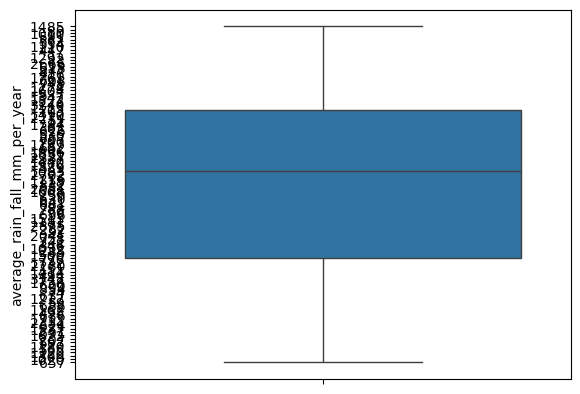

In [69]:
sns.boxplot(master_df['average_rain_fall_mm_per_year'])
plt.show()

No outliers were seen, so the '..' would be replaced using the mean

In [70]:
# Step 1: Replace '..' with NaN
master_df['average_rain_fall_mm_per_year'] = master_df['average_rain_fall_mm_per_year'].replace('..', np.nan)

# Step 2: Convert column to numeric
master_df['average_rain_fall_mm_per_year'] = pd.to_numeric(
    master_df['average_rain_fall_mm_per_year'],
    errors='coerce'
)

# Step 3: Replace NaN with mean
mean_value = master_df['average_rain_fall_mm_per_year'].mean()
master_df['average_rain_fall_mm_per_year'] = master_df['average_rain_fall_mm_per_year'].fillna(mean_value)

# Step 4: Verify
print(master_df['average_rain_fall_mm_per_year'].isnull().sum())  # should be 0
print(master_df['average_rain_fall_mm_per_year'].head())

0
0    1485.0
1    1485.0
2    1485.0
3    1485.0
4    1485.0
Name: average_rain_fall_mm_per_year, dtype: float64


# Univariate Analysis

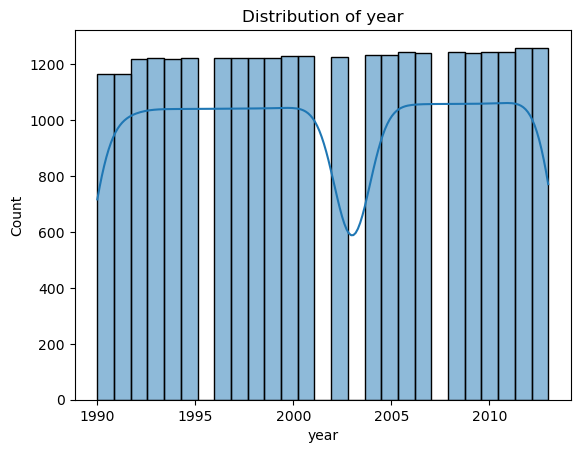

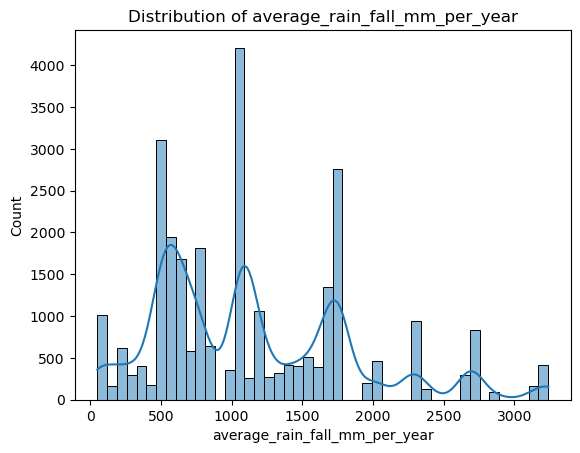

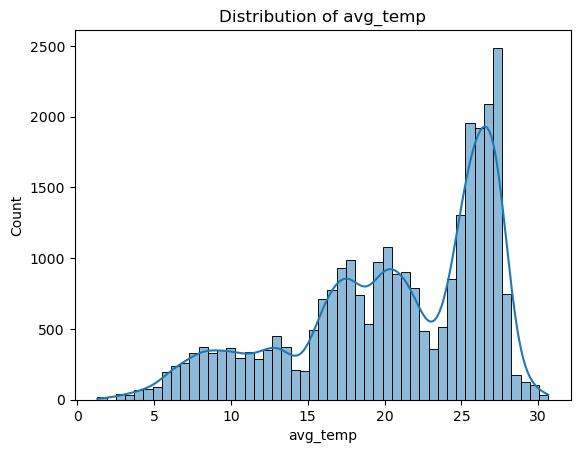

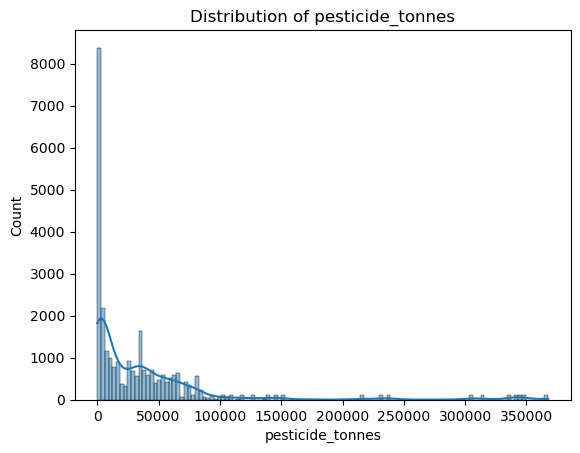

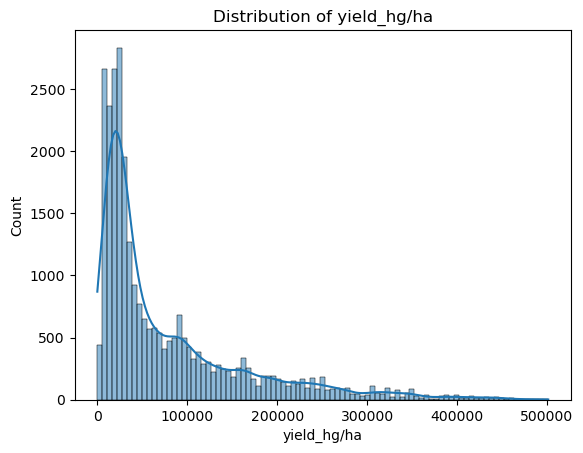

In [71]:
#Distribution of the numerical variables
num_cols = master_df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    sns.histplot(master_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

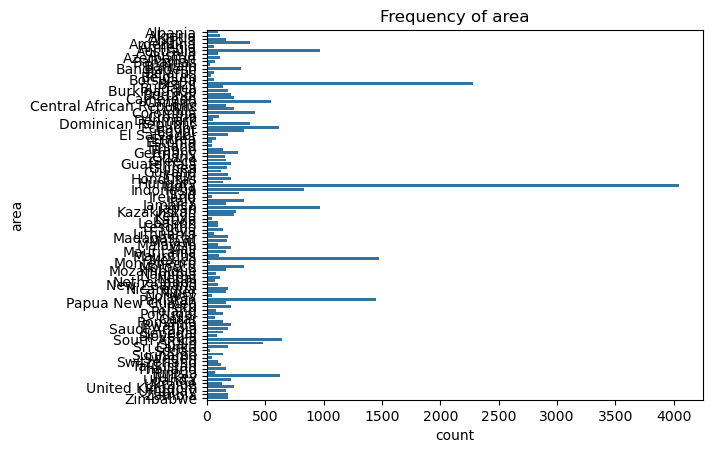

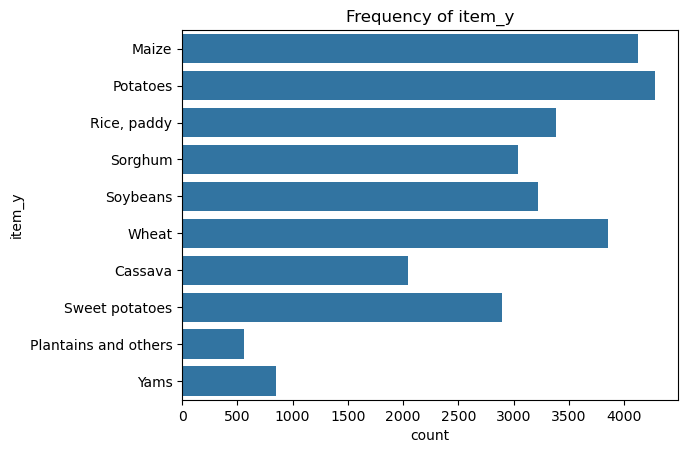

In [72]:
#Distribution of categorical variables
cat_cols = master_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    sns.countplot(y=col, data=master_df)
    plt.title(f'Frequency of {col}')
    plt.show()

# Bivariate Analysis

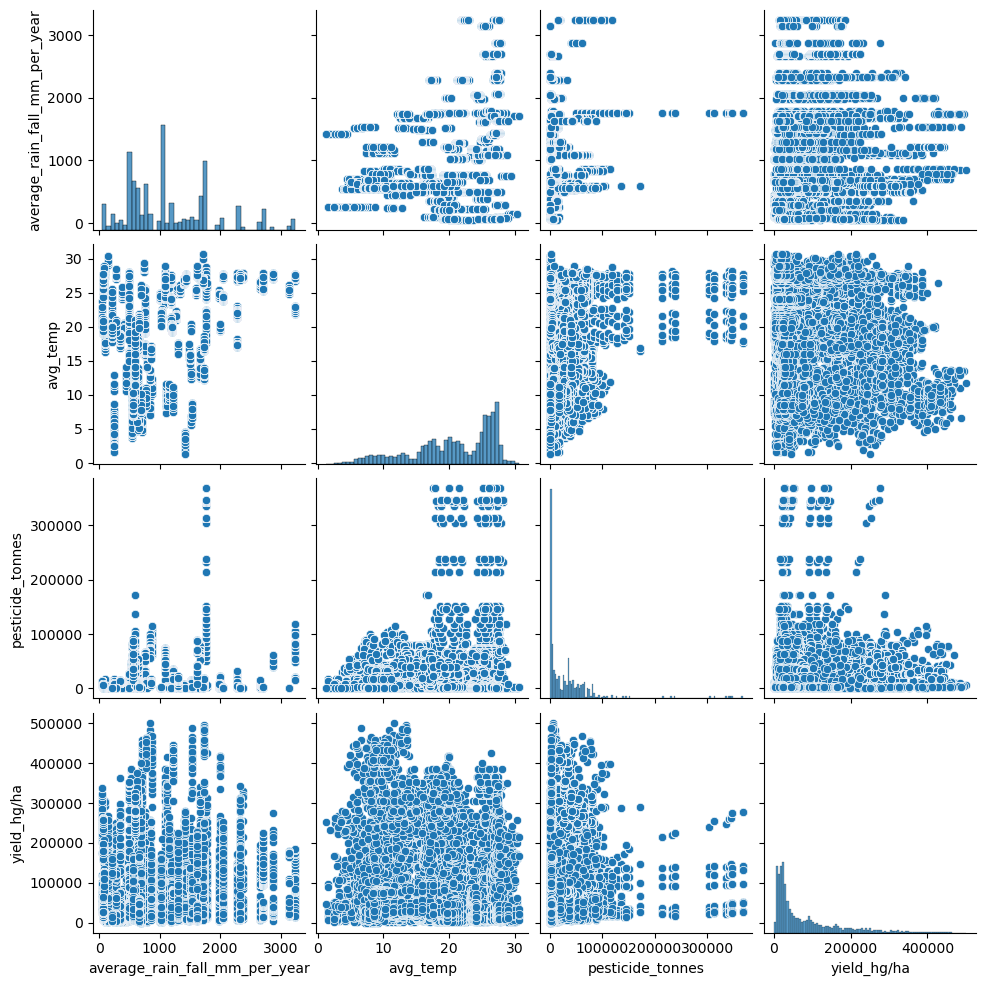

In [73]:
#Explore how independent variables relate to the target variable  'yield'
sns.pairplot(master_df, vars=['average_rain_fall_mm_per_year', 'avg_temp', 'pesticide_tonnes', 'yield_hg/ha'])
plt.show()

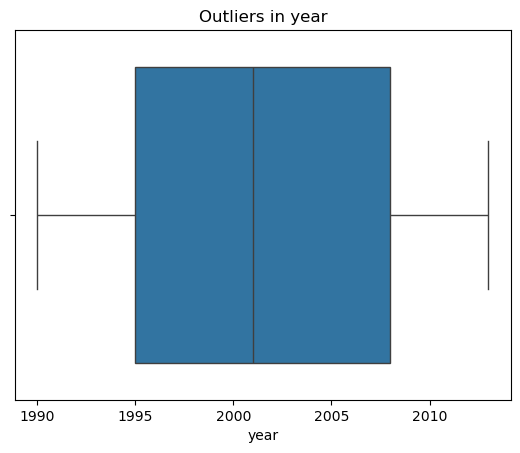

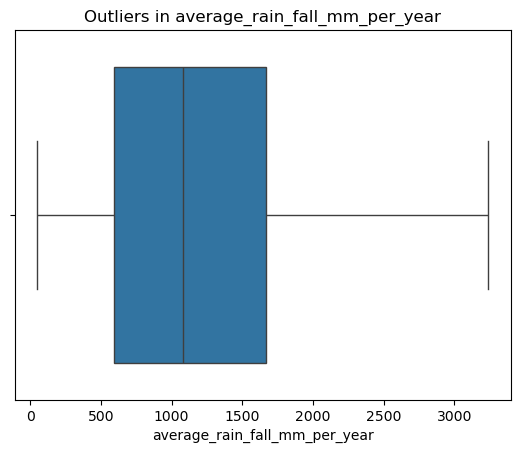

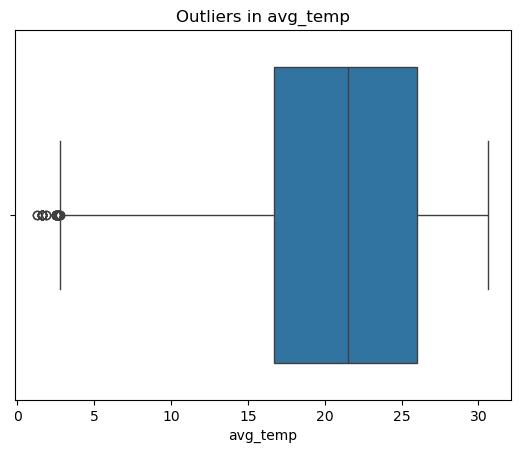

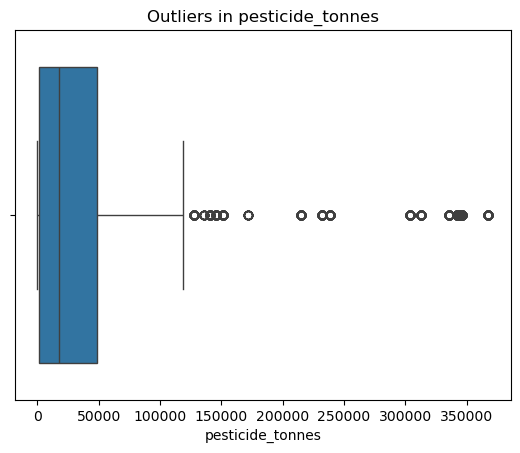

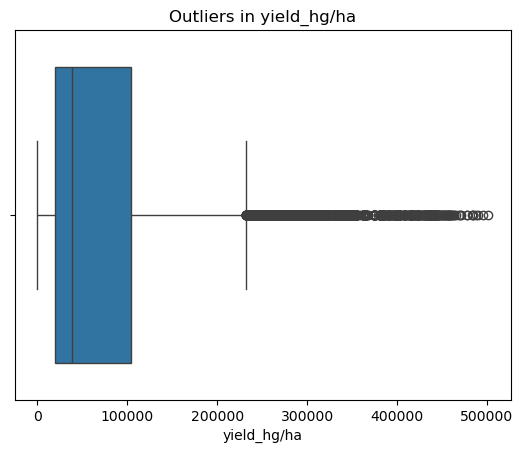

In [74]:
#Outliers Detection
for col in num_cols:
    sns.boxplot(x=master_df[col])
    plt.title(f'Outliers in {col}')
    plt.show()


In [75]:
numeric_cols = ['average_rain_fall_mm_per_year', 'pesticide_tonnes', 'avg_temp', 'yield_hg/ha']
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers

for col in numeric_cols:
    outliers = detect_outliers(master_df, col)
    print(f"{col}: {len(outliers)} outliers")

average_rain_fall_mm_per_year: 0 outliers
pesticide_tonnes: 1418 outliers
avg_temp: 34 outliers
yield_hg/ha: 2059 outliers


# Check the distribution of columns with outliers

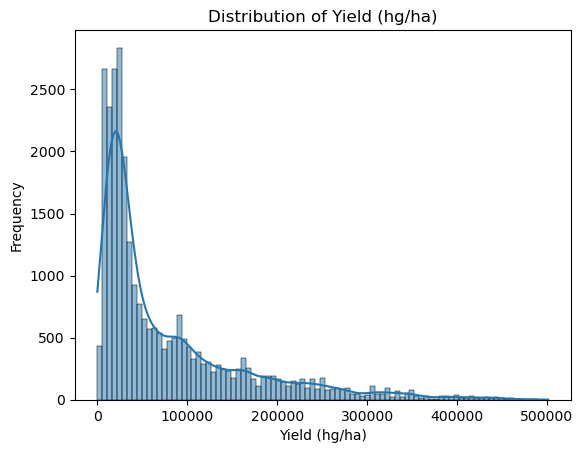

In [76]:
sns.histplot(master_df['yield_hg/ha'], kde=True)
plt.title("Distribution of Yield (hg/ha)")
plt.xlabel("Yield (hg/ha)")
plt.ylabel("Frequency")
plt.show()

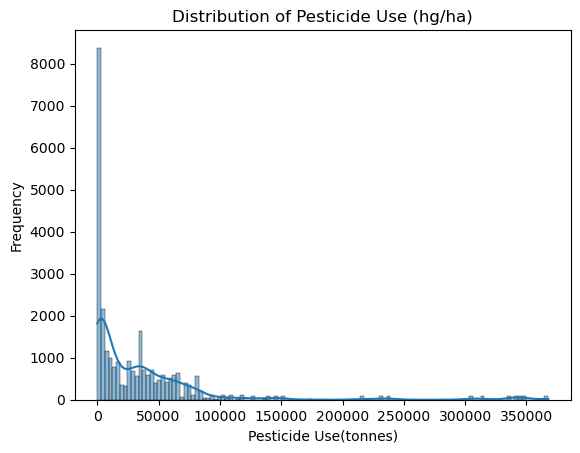

In [77]:
sns.histplot(master_df['pesticide_tonnes'],kde=True)
plt.title("Distribution of Pesticide Use (hg/ha)")
plt.xlabel("Pesticide Use(tonnes)")
plt.ylabel("Frequency")
plt.show()

Interpretation of Yield and Pesticide Use Distribution

Heavily Right-Skewed Distribution:
Most yield values are concentrated near the lower range (0–50,000 hg/ha) and 0 tonnes.
A few extreme values stretch far out toward 500,000 hg/ha and 350000 tonnes — clear outliers.

# Trend Analysis Over Time - how the key variables(temperature,rainfall,pesticide use, yield) changes by year

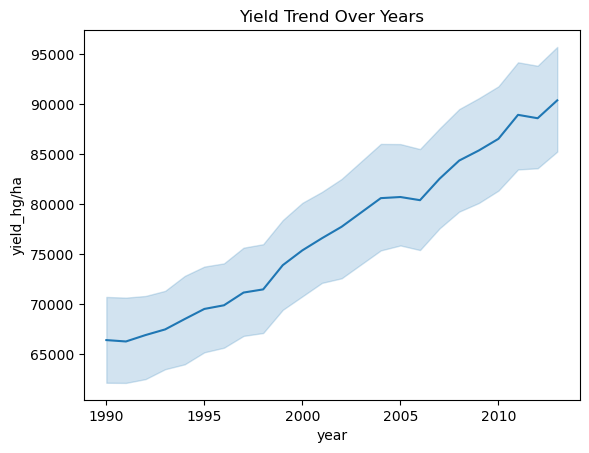

In [78]:
sns.lineplot(x='year', y='yield_hg/ha', data=master_df)
plt.title('Yield Trend Over Years')
plt.show()

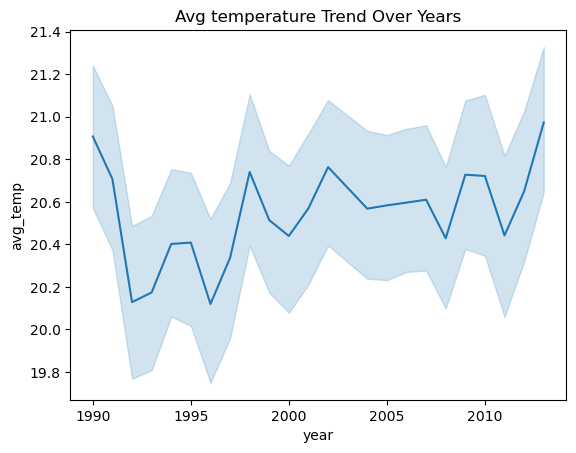

In [79]:
sns.lineplot(x='year', y='avg_temp', data=master_df)
plt.title('Avg temperature Trend Over Years')
plt.show()

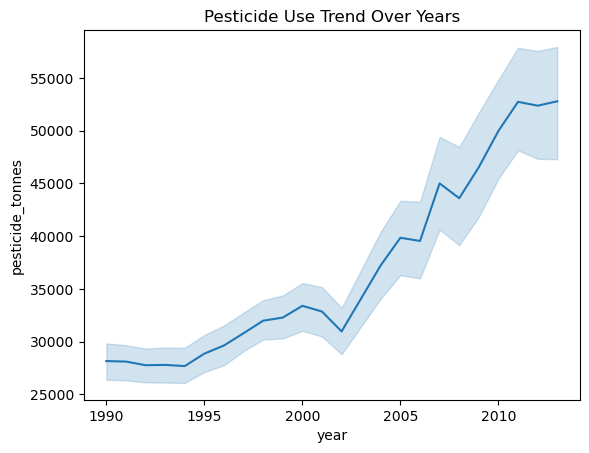

In [80]:
sns.lineplot(x='year', y='pesticide_tonnes', data=master_df)
plt.title('Pesticide Use Trend Over Years')
plt.show()

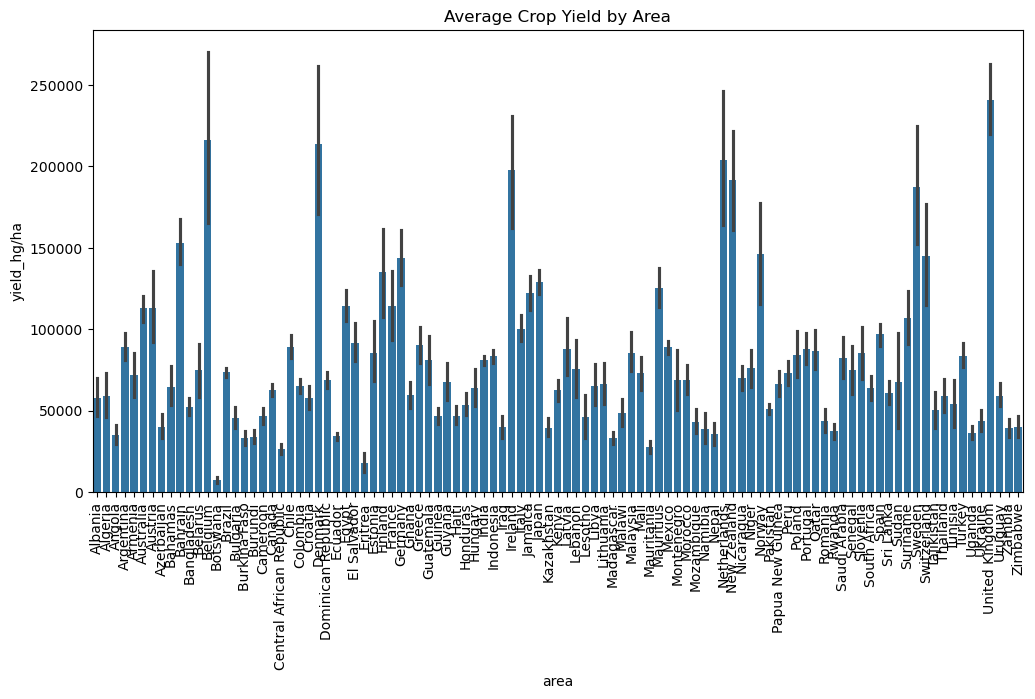

In [81]:
#Categorical Comparison
plt.figure(figsize=(12,6))
sns.barplot(x='area', y='yield_hg/ha', data=master_df)
plt.xticks(rotation=90)
plt.title('Average Crop Yield by Area')
plt.show()

# Feature Preprocessing & Train/Test Split

In [82]:
# Defining Features (X) and Target (y) ---
print("\n--- Starting Feature Preprocessing ---")

X = master_df.drop(columns=["yield_hg/ha"])
y = master_df["yield_hg/ha"]

# Initializing and fitting the LabelEncoders HERE
print("Encoding categorical features...")
le_area = LabelEncoder().fit(df['area'])
le_item = LabelEncoder().fit(df['item'])

# Applying encoders
X['area_encoded'] = le_area.fit_transform(X['area'])
X['item_encoded'] = le_item.fit_transform(X['item_y'])
    
# Dropping the original object columns
X = X.drop(columns=['area', 'item_y'])
    
print("Features after encoding:")
print(X.head())

# --- 4. Feature Scaling ---

print("\n--- Scaling Features ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Feature scaling complete.")


--- Starting Feature Preprocessing ---
Encoding categorical features...
Features after encoding:
   year  average_rain_fall_mm_per_year  avg_temp  pesticide_tonnes  \
0  1990                         1485.0     16.37             121.0   
1  1990                         1485.0     16.37             121.0   
2  1990                         1485.0     16.37             121.0   
3  1990                         1485.0     16.37             121.0   
4  1990                         1485.0     16.37             121.0   

   area_encoded  item_encoded  
0             0             1  
1             0             3  
2             0             4  
3             0             5  
4             0             6  

--- Scaling Features ---
Feature scaling complete.


In [83]:
# Perform train-test split
print("\n--- Performing Train-Test Split ---")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
print("\n--- Scaling Features ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")
print("Feature scaling complete.")


--- Performing Train-Test Split ---

--- Scaling Features ---
Training set shape: (22598, 6)
Testing set shape: (5650, 6)
Feature scaling complete.



Generating correlation heatmap...


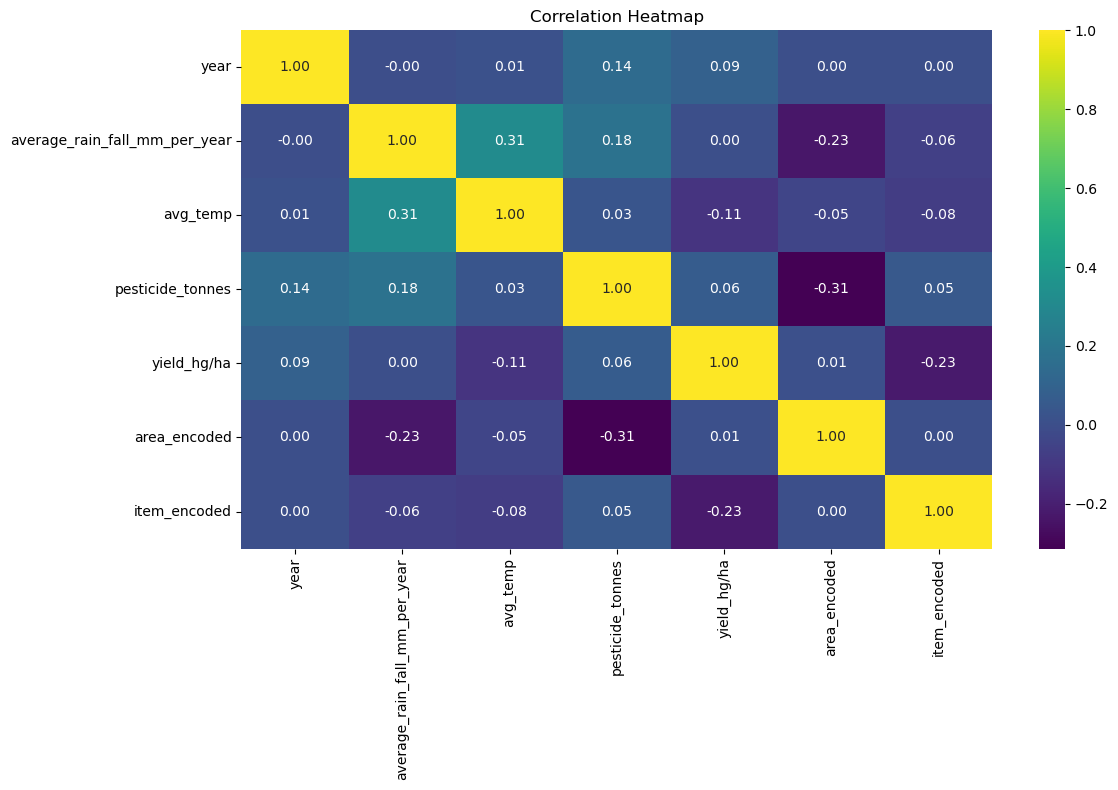

In [84]:

# --- Correlation Heatmap ---
print("\nGenerating correlation heatmap...")

# Copying a new DataFrame for this plot
df_corr = master_df.copy()

# Encoding categorical features ('area' and 'item_y')
le_area_corr = LabelEncoder()
le_item_corr = LabelEncoder()
df_corr['area_encoded'] = le_area_corr.fit_transform(df_corr['area'])
df_corr['item_encoded'] = le_item_corr.fit_transform(df_corr['item_y'])

# Select only numeric/encoded columns for correlation
numeric_features = ['year', 'average_rain_fall_mm_per_year', 'avg_temp', 'pesticide_tonnes', 'yield_hg/ha', 'area_encoded', 'item_encoded']

plt.figure(figsize=(12, 8))
sns.heatmap(df_corr[numeric_features].corr(), 
            annot=True, 
            cmap='viridis', 
            fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

Train, Test, Split validation

In [85]:
print("\n--- Splitting Data ---")

def custom_train_test_split(X, y, test_size=0.2, random_seed=42):
        """
        Splits X and y into training and testing sets from scratch.
        """
        np.random.seed(random_seed)
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        test_set_size = int(X.shape[0] * test_size)
        test_indices = indices[:test_set_size]
        train_indices = indices[test_set_size:]
        return X.iloc[train_indices], X.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]
    
#  Comparing Split functions ---
X_train_custom, X_test_custom, y_train_custom, y_test_custom = custom_train_test_split(X, y, test_size=0.2, random_seed=42)

print(f"--Custom Split X_train shape: {X_train_custom.shape}")
print(f"X_train shape: {X_train_custom.shape}")
print(f"X_test shape: {X_test_custom.shape}")
print(f"y_train shape: {y_train_custom.shape}")
print(f"y_test shape: {y_test_custom.shape}")
    
 # Using scikit-learn's function for the rest of the project
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n --Scikit-learn Split X_train shape: {X_train.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


--- Splitting Data ---
--Custom Split X_train shape: (22599, 6)
X_train shape: (22599, 6)
X_test shape: (5649, 6)
y_train shape: (22599,)
y_test shape: (5649,)

 --Scikit-learn Split X_train shape: (22598, 6)
X_train shape: (22598, 6)
X_test shape: (5650, 6)
y_train shape: (22598,)
y_test shape: (5650,)


# Feature Scaling

In [86]:
scaler = StandardScaler()

# Fitting on training data and transforming it
X_train_scaled = scaler.fit_transform(X_train)
    
# Transforming the test data
X_test_scaled = scaler.transform(X_test)
print("Feature scaling complete.")

Feature scaling complete.


# Modeling 

In [87]:
# Modeling 
print("\n--- Training Models ---")

# Initialize model_results dictionary
model_results = {}


--- Training Models ---


In [88]:
# 1. Random Forest Regressor
print("Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf:.2f}")

Training Random Forest...
Random Forest MSE: 120854300.45


In [89]:
# 2. Linear Regression
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
model_results['Linear Regression'] = {'model': lr_model, 'mse': mse_lr}
print(f"Linear Regression MSE: {mse_lr:.2f}")

Training Linear Regression...
Linear Regression MSE: 6732532084.24


In [90]:
# 3. XGBoost Regressor
print("Training XGBoost...")
try:
    xgb_model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, objective='reg:squarederror')
    xgb_model.fit(X_train_scaled, y_train)
    y_pred_xgb = xgb_model.predict(X_test_scaled)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    print(f"XGBoost MSE: {mse_xgb:.2f}")
except Exception as e:
    print(f"Could not train XGBoost. Error: {e}")
    print("Defaulting to Random Forest as the best model.")
    mse_xgb = float('inf') 
 


Training XGBoost...
XGBoost MSE: 205110864.00


In [91]:
# 4. Storing results for all models
model_results = {
 'Linear Regression': {'model': lr_model, 'mse': mse_lr},
 'Random Forest': {'model': rf_model, 'mse': mse_rf},
 'XGBoost': {'model': xgb_model, 'mse': mse_xgb}
}

# Finding the best model
best_model_name = min(model_results, key=lambda k: model_results[k]['mse'])
best_model = model_results[best_model_name]['model']

print(f"\n--- Best Model: {best_model_name} (MSE: {model_results[best_model_name]['mse']:.2f}) ---")
print("\nModel Performance Summary:")
for model_name, results in model_results.items():
 print(f"{model_name} MSE: {results['mse']:.2f}")


--- Best Model: Random Forest (MSE: 120854300.45) ---

Model Performance Summary:
Linear Regression MSE: 6732532084.24
Random Forest MSE: 120854300.45
XGBoost MSE: 205110864.00


In [92]:
# 4. Choosing the Best Model 
# Find the model with the lowest MSE
best_model_name = min(model_results, key=lambda k: model_results[k]['mse'])
best_model = model_results[best_model_name]['model']
    
print(f"\n--- Best Model: {best_model_name} (MSE: {model_results[best_model_name]['mse']:.2f}) ---")


--- Best Model: Random Forest (MSE: 120854300.45) ---


Saving the Model and Scaler

In [93]:
print("Saving Model and Encoders ")
    
pickle.dump(best_model, open('crop_yield_model.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))
pickle.dump(le_area, open('le_area.pkl', 'wb'))
pickle.dump(le_item, open('le_item.pkl', 'wb'))
    
print("Model, Scaler, and Encoders saved to disk.")

Saving Model and Encoders 
Model, Scaler, and Encoders saved to disk.


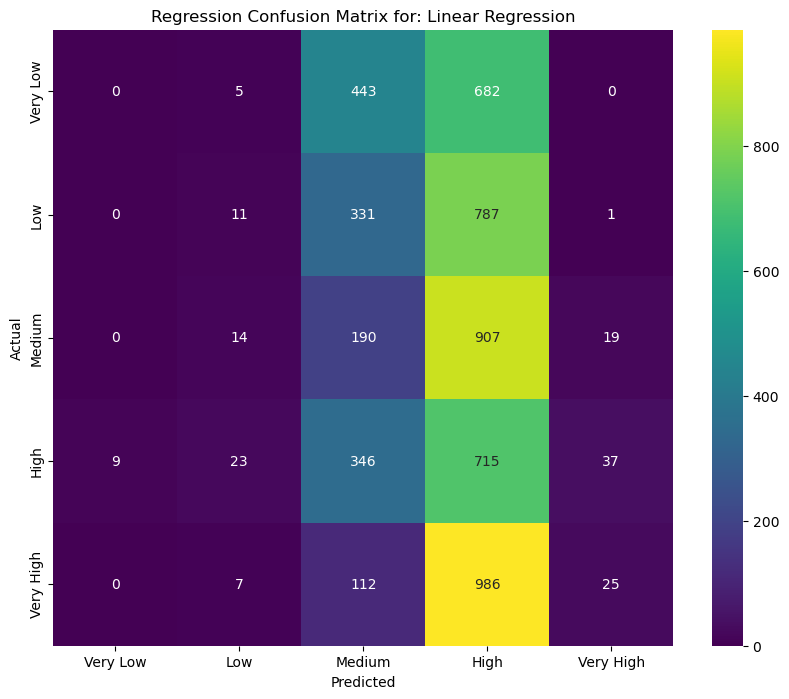

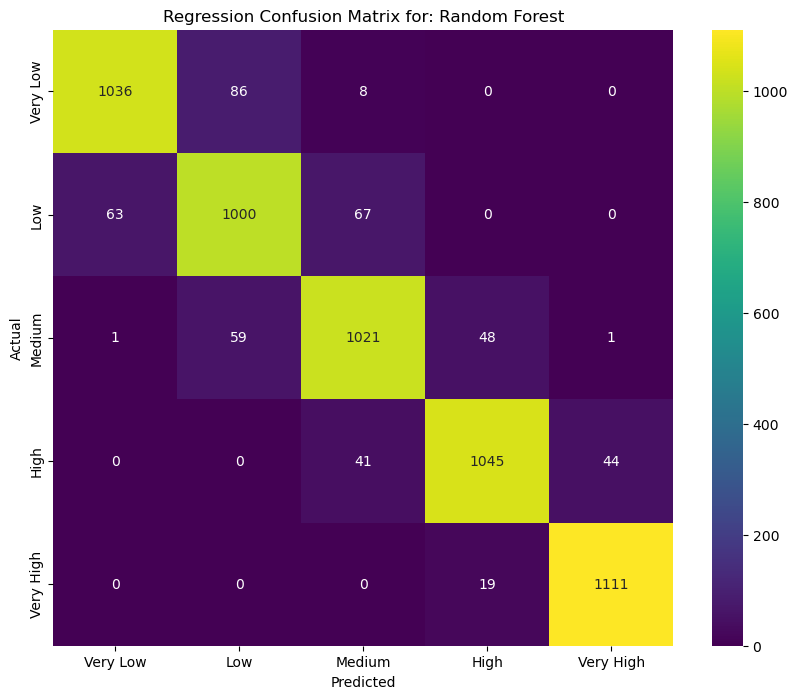

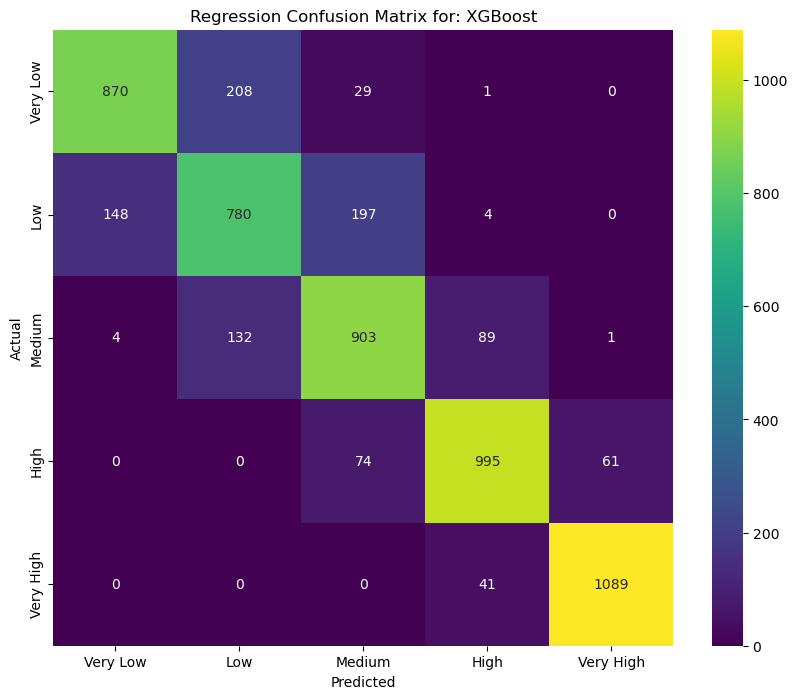

In [94]:
# Getting Predictions for ALL Models

y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_xgb = xgb_model.predict(X_test_scaled) # Assumes xgb_model was successfully trained

# Storing them in a dictionary
predictions = {
    "Linear Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb 
}

# --- Defining the Bins ---
# We'll use quintiles (5 bins: 0-20%, 20-40%, 40-60%, 60-80%, 80-100%)
# We get the bin edges from the REAL data (y_test)
bin_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
try:
    # 'bins' will store the edges, e.g., [min, 10000, 30000, 50000, 70000, max]
    bins = pd.qcut(y_test, q=5, retbins=True)[1] 
except ValueError as e:
    # Handling case where quintiles are not possible (e.g., duplicate edges)
    print(f"Warning: Could not create 5 bins, defaulting to 4: {e}")
    bin_labels = ['Low', 'Medium', 'High', 'Very High']
    bins = pd.qcut(y_test, q=4, retbins=True)[1]

#  Creating a Plot for Each Model
for model_name, y_pred in predictions.items():
    
    # a. Converting actual and predicted numbers into bins
    # We will  use pd.cut() and apply the *same bins* to both
    actual_bins = pd.cut(y_test, bins=bins, labels=bin_labels, include_lowest=True)
    predicted_bins = pd.cut(y_pred, bins=bins, labels=bin_labels, include_lowest=True)
    
    # b. Creating the confusion matrix using crosstab
    matrix = pd.crosstab(
        index=actual_bins, 
        columns=predicted_bins, 
        rownames=['Actual'], 
        colnames=['Predicted'],
        dropna=False # Include NaNs if any predictions fall out of bounds
    )
    
    # c. Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='viridis')
    plt.title(f'Regression Confusion Matrix for: {model_name}')
    plt.show()

# Model Evaluation

In [95]:
# --- 5. Models Evaluation---
print("\n--- Evaluating  The Training Models ---")
model_results = {}


# --- This loop calculates the correct metrics for each model ---
for model_name, model in [('Linear Regression', lr_model), 
                         ('Random Forest', rf_model), 
                         ('XGBoost', xgb_model)]:
    
    y_pred = model.predict(X_test_scaled)
    
    # --- Here are the regression metrics ---
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred) # This is the R-squared
    
    print(f"\n--- {model_name} Evaluation ---")
    print(f"  R-squared (R²): {r2:.4f}")
    print(f"  Mean Squared Error (MSE): {mse:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
    
    model_results[model_name] = {'model': model, 'mse': mse}

# ... (Choosing the best model based on the lowest MSE) ...


--- Evaluating  The Training Models ---

--- Linear Regression Evaluation ---
  R-squared (R²): 0.0827
  Mean Squared Error (MSE): 6732532084.24
  Root Mean Squared Error (RMSE): 82052.01

--- Random Forest Evaluation ---
  R-squared (R²): 0.9835
  Mean Squared Error (MSE): 120854300.45
  Root Mean Squared Error (RMSE): 10993.38

--- XGBoost Evaluation ---
  R-squared (R²): 0.9721
  Mean Squared Error (MSE): 205110864.00
  Root Mean Squared Error (RMSE): 14321.69


# Feature Importance


--- Generating Feature Importance Plot ---
Feature count: 6, Importance count: 6


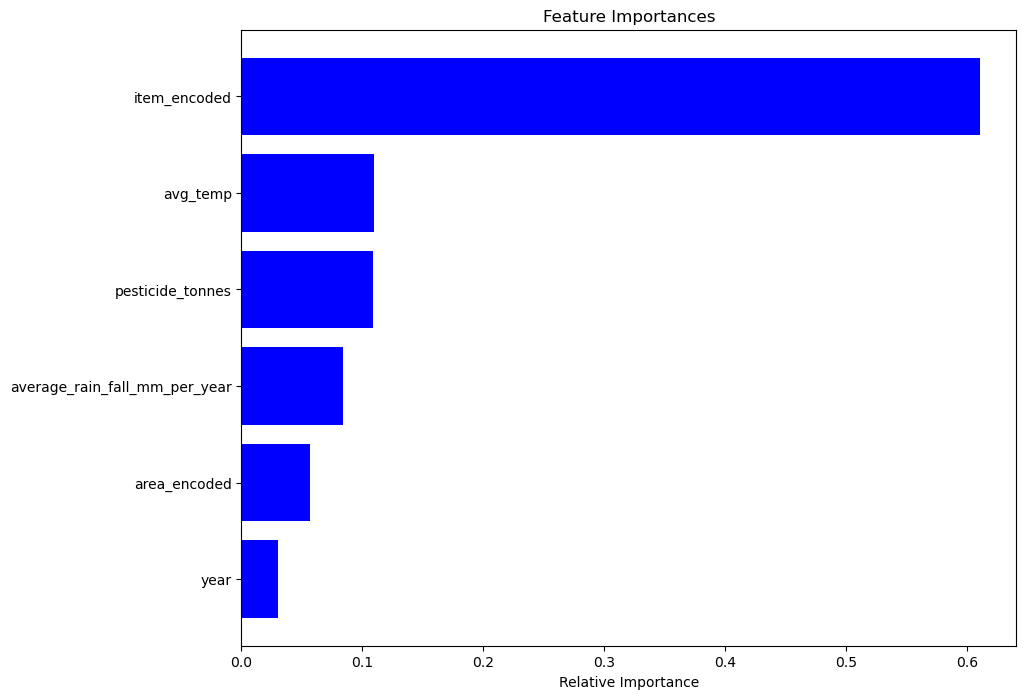

In [96]:
print("\n--- Generating Feature Importance Plot ---")
    

# Defining 'features' from the columns of 'X' DataFrame used for training
features = X.columns
    
# Get importances from the *final* best_model
importances = best_model.feature_importances_
indices = np.argsort(importances)

# Sanity check
print(f"Feature count: {len(features)}, Importance count: {len(importances)}")
    
plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    

plt.yticks(range(len(indices)), [features[i] for i in indices])
    
plt.xlabel('Relative Importance')
plt.show()